In [1]:
import os

import xarray as xr
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta 
from pandas import Timedelta
import zarr

import gcsfs

from dask.distributed import Client

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:46375 Dashboard: /user/acannistra/proxy/8787/status,Cluster Workers: 4 Cores: 16 Memory: 25.77 GB


<h1><a href="https://www.ncdc.noaa.gov/oisst">OISST</a> to <code>zarr</code> via <code>xarray</code> and <code>dask</code></h1>


[Tony Cannistra](https://www.github.com/acannistra), January 2020

---

This notebook turns the OISST data from NOAA into a `zarr` directory for upload to cloud storage. 

**Components**:

* Download OISST Data 
* Prepare OISST data as xarray `mfdataset`
* Chunk OISST data through time (due to memory constraints)
* Append each OISST chunk to local `zarr` object. 
* [optional] Upload local `zarr` to Google Cloud Storage. 

In [3]:
# parameters / directories
LOCAL_OISST = 'data/'
LOCAL_ZARR = '/tmp/oisst.zarr'
TIME_CHUNK_SIZE_YEARS = 3

## Download OISST

In [4]:
#TODO

## Prepare OISST `xarray.Dataset`

In [5]:
oisst = xr.open_mfdataset(os.path.join(LOCAL_OISST, "*.nc"), combine='nested', concat_dim = 'time', parallel=True)
oisst

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 13636)
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time     (time) datetime64[ns] 1981-09-01 1981-09-02 ... 2018-12-31
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(122, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.5
    title:          NOAA High-resolution Blended Analysis: Daily Values using...
    institution:    NOAA/NCDC
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Reynolds, et al., 2007: Daily High-Resolution-Blended Ana...
    history:        Thu Aug 24 13:34:17 2017: ncatted -O -a References,global...
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature

In [6]:
## Need to chunk the data uniformly
oisst = oisst.chunk({
    'time': 100, 
    'lat' : 50,
    'lon' : 500
})

In [10]:
oisst.sst.data

,Array,Chunk
Bytes,56.55 GB,10.00 MB
Shape,"(13636, 720, 1440)","(100, 50, 500)"
Count,14109 Tasks,6165 Chunks
Type,float32,numpy.ndarray


In [11]:
## Create zarr compression encoding 
compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)
encoding = {vname: {'compressor': compressor} for vname in oisst.variables}
encoding

{'lon': {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)},
 'lat': {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)},
 'time': {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)},
 'sst': {'compressor': Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)}}

## Create time-based slices of OISST and append to `zarr`

In [12]:
time_chunk_start = datetime.utcfromtimestamp(int(oisst.time.min().values.astype('O')//1e9))
max_observation_date = datetime.utcfromtimestamp(int(oisst.time.max().values.astype('O')//1e9))
year_delta = relativedelta(years=TIME_CHUNK_SIZE_YEARS)
day_offset = relativedelta(days=1)

first_write = True

while time_chunk_start < max_observation_date:
    time_chunk_end = time_chunk_start + year_delta
    print(time_chunk_start, time_chunk_end)
    timechunk = oisst.sel(time = slice(
        str(time_chunk_start), 
        str(time_chunk_end)
    ))
    if first_write:
        _action = timechunk.to_zarr(LOCAL_ZARR, compute=False, mode='w', encoding=encoding)
        first_write = False
    else: 
        _action = timechunk.to_zarr(LOCAL_ZARR, compute=False, mode='a', append_dim='time')
    
    try:
        _action.compute()
    except: 
        print("ERROR: {}".format(time_chunk_start, time_chunk_end))
        continue
    time_chunk_start = time_chunk_end + day_offset
    
    

1981-09-01 00:00:00 1984-09-01 00:00:00
1984-09-02 00:00:00 1987-09-02 00:00:00
1987-09-03 00:00:00 1990-09-03 00:00:00
1990-09-04 00:00:00 1993-09-04 00:00:00
1993-09-05 00:00:00 1996-09-05 00:00:00
1996-09-06 00:00:00 1999-09-06 00:00:00
1999-09-07 00:00:00 2002-09-07 00:00:00
2002-09-08 00:00:00 2005-09-08 00:00:00
2005-09-09 00:00:00 2008-09-09 00:00:00
2008-09-10 00:00:00 2011-09-10 00:00:00
2011-09-11 00:00:00 2014-09-11 00:00:00
2014-09-12 00:00:00 2017-09-12 00:00:00
2017-09-13 00:00:00 2020-09-13 00:00:00


## Examine Resulting `zarr`

In [13]:
oisst_z = xr.open_zarr(LOCAL_ZARR)

In [14]:
oisst_z.sst.data

,Array,Chunk
Bytes,56.55 GB,10.00 MB
Shape,"(13636, 720, 1440)","(100, 50, 500)"
Count,6166 Tasks,6165 Chunks
Type,float32,numpy.ndarray


In [ ]:
mean_sst = oisst_z.sst.mean(dim='time').compute() # ~5 minutes

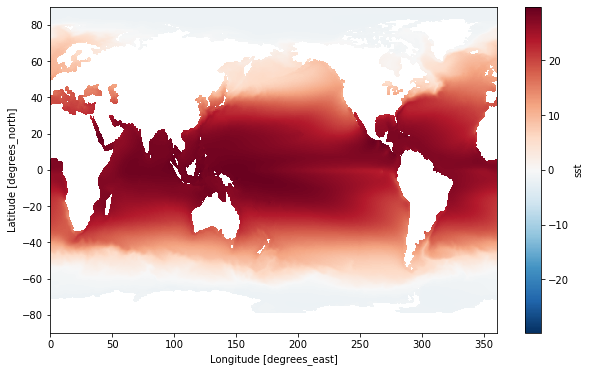

In [21]:
fig = plt.figure(figsize=(10,6))
mean_sst.plot()

In [24]:
mean_sst_slice = oisst_z.sel(lat=slice(25, 60), lon = slice(220, 250)).sst.mean(dim='time').compute() # faster (20s)

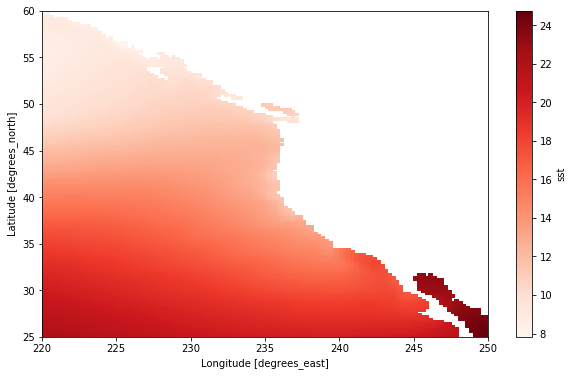

In [36]:
fig = plt.figure(figsize=(10,6))

mean_sst_slice.plot(cmap='Reds')

## [optional] Upload to GCS

*takes ~5m*

In [ ]:
%%bash
source ~/.bashrc
gsutil -m cp -r /tmp/oisst.zarr/ gs://oisst

### Assess functionality of GCP `zarr`

In [3]:
gcp_project_id = '170771369993'
fs = gcsfs.GCSFileSystem(project=gcp_project_id, token="/home/jovyan/gc-pangeo-storage.json")

In [4]:
oisst_gcp_z = xr.open_zarr(fs.get_mapper('oisst/oisst.zarr'))

In [5]:
oisst_gcp_z.sst.data

,Array,Chunk
Bytes,56.55 GB,10.00 MB
Shape,"(13636, 720, 1440)","(100, 50, 500)"
Count,6166 Tasks,6165 Chunks
Type,float32,numpy.ndarray


In [6]:
mean_sst_slice = oisst_gcp_z.sel(lat=slice(25, 60), lon = slice(220, 250)).sst.mean(dim='time').compute() # faster (20s)

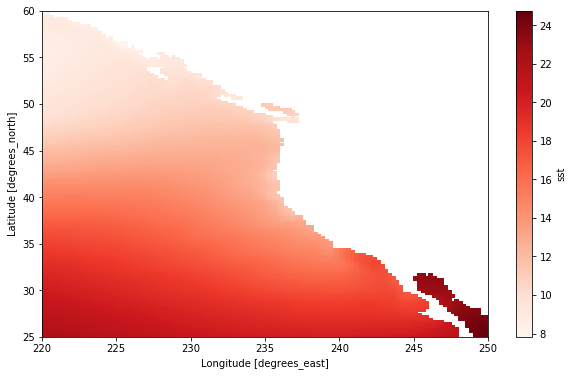

In [7]:
fig = plt.figure(figsize=(10,6))

mean_sst_slice.plot(cmap='Reds')

<font size="10">👌</font>

--- 
**Notes**:

* There was trouble initially trying to get the `zarr` object directly into GCS (via `gscfs.mapper` objects passed to `to_zarr`). This is documented somewhat at [pangeo/#741](https://github.com/pangeo-data/pangeo/issues/741) and [pangeo/#150](https://github.com/pangeo-data/pangeo/issues/150), and there doesn't seem to be a quick fix. We went with the local creation then cloud upload strategy for this reason.
* This approach was motivated by the Pangeo Data guide, available here: https://pangeo.io/data.html#guide-to-preparing-cloud-optimized-data

<img src="https://s3-us-west-2.amazonaws.com/uw-s3-cdn/wp-content/uploads/sites/98/2014/09/07214435/Signature_Stacked_Purple_Hex.png" width="80px" align="center"/>